<a href="https://colab.research.google.com/github/caroldaza/DM_CyT/blob/main/smallworldofwords_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [4]:
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

import numpy as np
import pandas as pd   

!pip install networkx powerlaw community

import networkx as nx
import community
import powerlaw
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from sklearn.metrics import adjusted_rand_score

from networkx.algorithms.community import modularity
import community.community_louvain as community_louvain

In [5]:
filename = '/content/drive/MyDrive/SWOW-EN.R100.csv.zip'
datos = pd.read_csv(filename, sep=',')
datos.head()

,Unnamed: 0,id,participantID,age,gender,nativeLanguage,country,education,created_at,cue,R1,R2,R3
0,1,29,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,although,nevertheless,yet,but
1,2,30,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,deal,no,cards,shake
2,3,31,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,music,notes,band,rhythm
3,4,32,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,inform,tell,rat on,NaN
4,5,33,3,33,Fe,United States,Australia,NaN,2011-08-12 02:19:38,way,path,via,method


In [6]:
# Nos quedamos solo con la cue y la primera palabra. Tambien botamos Nans
data = datos.loc[:,['cue','R1']]
data = data.dropna(how='any')

# Sacar palabras de una letra
data.drop(data[data['cue'].str.len().lt(2)].index, inplace=True)
data.drop(data[data['R1'].str.len().lt(2)].index, inplace=True)

data.head()

,cue,R1
0,although,nevertheless
1,deal,no
2,music,notes
3,inform,tell
4,way,path


In [ ]:
data.shape[0]

1194119

In [ ]:
# ¿Cuántas claves y respuestas son únicas?
print(data['cue'].unique().shape)
print(data['R1'].unique().shape)

(12258,)
(64663,)


In [ ]:
# ¿cuántas palabras de R1 están en Cue? ¿alrevés?
print(sum(data['R1'].isin(data['cue'].unique())))
print(sum(data['cue'].isin(data['R1'].unique())))

1067977
1185365


In [7]:
# Sacar palabras que no este en cue Y en R1
data.drop(data[data['R1'].isin(data['cue'].unique())==False].index, inplace=True)
data.drop(data[data['cue'].isin(data['R1'].unique())==False].index, inplace=True)

In [10]:
data.shape[0]

1060109

In [8]:
# la frecuencia de cada cue
new_df = data['cue'].str.split(expand=True).stack().value_counts().reset_index()
new_df.columns = ['Word', 'Frequency'] 

In [37]:
new_df

,Word,Frequency
0,up,2021
1,not,1167
2,out,1061
3,on,961
4,down,830
...,...,...
11868,ping,33
11869,Homer,29
11870,adrenal,26
11871,Sherlock,23


Text(0, 0.5, 'frequency')

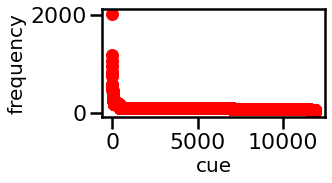

In [48]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.plot(new_df['Frequency'],'ro')
plt.xlabel("cue",fontsize=20)
plt.ylabel("frequency",fontsize=20)

Text(0, 0.5, 'frequency')

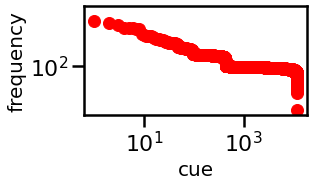

In [39]:
#plt.loglog(np.linspace(1, len(new_df['Frequency']),len(new_df['Frequency'])),new_df['Frequency'].to_numpy())
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(new_df['Frequency'],'ro')
plt.xlabel("cue",fontsize=20)
plt.ylabel("frequency",fontsize=20)

In [12]:
# la frecuencia de cada R1
new_df_R1 = data['R1'].str.split(expand=True).stack().value_counts().reset_index()
new_df_R1.columns = ['Word', 'Frequency'] 

Text(0, 0.5, 'frequency')

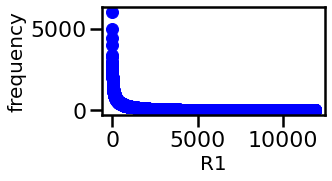

In [47]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.plot(new_df_R1['Frequency'],'bo')
plt.xlabel("R1",fontsize=20)
plt.ylabel("frequency",fontsize=20)

Text(0, 0.5, 'frequency')

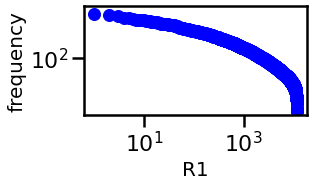

In [42]:
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(new_df_R1['Frequency'],'bo')
plt.xlabel("R1",fontsize=20)
plt.ylabel("frequency",fontsize=20)

In [9]:
#sacando los duplicados
data_0 = data[data.duplicated()]
print(data_0.shape[0])

674293


In [10]:
# calculando frecuencia de aparicion de cada cue
df1_0 = data_0.groupby(['cue']).size().to_frame(name='size').reset_index()
df1_0_sorted = df1_0.sort_values(by=['size'],ascending=False).reset_index()
df1_0_sorted.head(5)

,index,cue,size
0,62,Cheddar,92
1,7129,mozzarella,92
2,7059,moo,91
3,1909,cardiac,91
4,304,Sahara,91


In [11]:
# calculando frecuencia de aparicion de R1
df3_0 = data_0.groupby(['R1']).size().to_frame(name='size').reset_index()
df3_0_sorted = df3_0.sort_values(by=['size'],ascending=False).reset_index()
df3_0_sorted.head(5)

,index,R1,size
0,6499,money,5166
1,4149,food,3883
2,10915,water,3630
3,1760,car,3305
4,6619,music,2794


In [12]:
# calculando frecuencia de aparicion de cada par cue-R1
df2_0 = data_0.groupby(['cue','R1']).size().to_frame(name='size').reset_index()
df2_0_sorted = df2_0.sort_values(by=['size'],ascending=False).reset_index()
df2_0_sorted.head(5)

,index,cue,R1,size
0,591,Cheddar,cheese,92
1,2523,Parmesan,cheese,91
2,76260,moo,cow,90
3,55638,halt,stop,86
4,77017,mozzarella,cheese,85


In [13]:
df_0 = df2_0.merge(df1_0,left_on='cue',right_on='cue')
df_0 = df_0.rename(columns={'size_x':'frec_par','size_y':'frec_cue'})
df_0['frec'] = df_0['frec_par']/df_0['frec_cue']
df_0.head(5)

,cue,R1,frec_par,frec_cue,frec
0,Abel,Cain,54,59,0.915254
1,Abel,can,1,59,0.016949
2,Abel,cane,3,59,0.050847
3,Abel,religion,1,59,0.016949
4,Aboriginal,Australia,28,70,0.400000


distribuciones de frecuencias despues de limpiar datos

Text(0, 0.5, 'frequency')

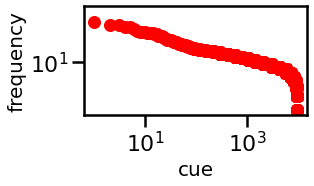

In [49]:
auxc = df_0['cue'].str.split(expand=True).stack().value_counts().reset_index()
auxc.columns = ['Word', 'Frequency'] 
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(auxc['Frequency'],'ro')
plt.xlabel("cue",fontsize=20)
plt.ylabel("frequency",fontsize=20)

Text(0, 0.5, 'frequency')

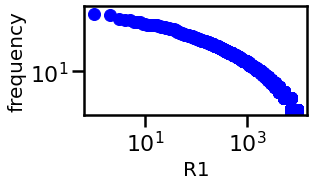

In [50]:
auxp = df_0['R1'].str.split(expand=True).stack().value_counts().reset_index()
auxp.columns = ['Word', 'Frequency'] 
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(2)
plt.yscale('log')
plt.xscale('log')
plt.plot(auxp['Frequency'],'bo')
plt.xlabel("R1",fontsize=20)
plt.ylabel("frequency",fontsize=20)

despues de limpiarlos se parecen un poco mas a una small world pero no son exactamente

In [14]:
# Recortando el grafo

df_0 = df_0[df_0['frec']>0.025]

# Sacar palabras que no estan mas en el cue y la R1 otra vez
df_0.drop(df_0[df_0['R1'].isin(df_0['cue'].unique())==False].index, inplace=True)
df_0.drop(df_0[df_0['cue'].isin(df_0['R1'].unique())==False].index, inplace=True)
print(df_0.shape[0])

75046


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
df_0.shape

(75046, 5)

Matriz de adyacencia

In [15]:
df_firstrows = pd.crosstab(df_0.cue, df_0.R1)
idx = df_firstrows.columns.union(df_firstrows.index)
matriz = df_firstrows.reindex(index = idx, columns=idx, fill_value=0) #armo la matriz de adyacencia

In [16]:
matriz.head()

,Abel,Aboriginal,Adam,Advil,Africa,African,Alaska,Albert,Alps,Alvin,Amazon,America,American,Antarctic,April,Arab,Arabic,Aries,Arizona,Arthur,Asia,Asian,Australia,Australian,BBQ,Bambi,Band-Aid,Barbie,Batman,Beatles,Beethoven,Belgium,Berlin,Beyoncé,Billy,Bob,Boston,Brazil,Britain,Britannica,...,yes,yesterday,yet,yield,yo,yo-yo,yoga,yogi,yogurt,yoke,yolk,you,young,younger,your,yours,yourself,youth,youthful,yuck,yucky,yuk,yum,yummy,yuppie,zeal,zealot,zebra,zero,zest,zesty,zip,zipper,zit,zodiac,zombie,zombies,zone,zoo,zoom
Abel,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Aboriginal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Adam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Advil,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Africa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Histograma de grados:

Text(0.5, 1.0, 'Histograma nodos Gsww')

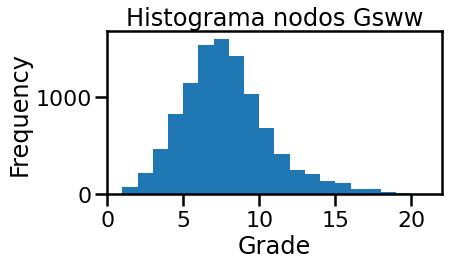

In [17]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.hist(np.sum(matriz, axis=1),bins=20)
plt.ylabel('Frequency')
plt.xlabel('Grade');
plt.title('Histograma nodos Gsww')

El grafo con la matriz de adyacencia:

In [18]:
G1_0= nx.from_pandas_adjacency(matriz)

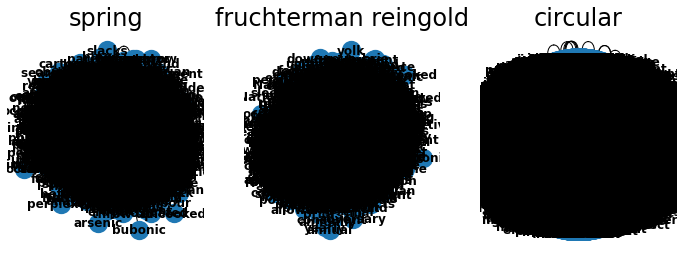

In [54]:
#Visualizando la red

plt.figure(figsize=(12,4))

plt.subplot(131)
nx.draw(G1, with_labels=True, font_weight='bold')
plt.title('spring')

plt.subplot(132)
layout=nx.fruchterman_reingold_layout(G1)
nx.draw(G1,layout, with_labels=True, font_weight='bold')
plt.title('fruchterman reingold')

plt.subplot(133)
layout=nx.circular_layout(G1)
nx.draw(G1,layout, with_labels=True, font_weight='bold')
plt.title('circular');

El grafo con la funcion edgelist (no entiendo bien la diferencia con el metodo de la matriz de adyacencia):

In [19]:
G1 = nx.from_pandas_edgelist(df_0[['cue','R1']],source='cue',target='R1',edge_attr=None)

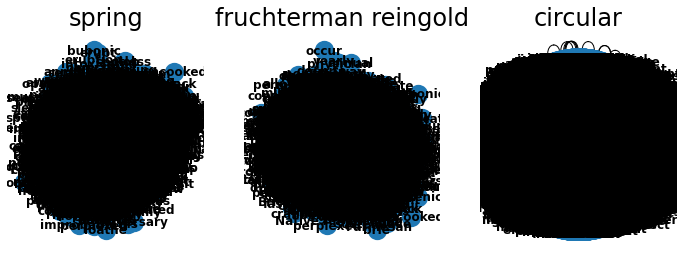

In [25]:
#Visualizando la red

plt.figure(figsize=(12,4))

plt.subplot(131)
nx.draw(G1, with_labels=True,alpha=0.6)
plt.title('spring')

plt.subplot(132)
layout=nx.fruchterman_reingold_layout(G1)
nx.draw(G1,layout, with_labels=True, alpha=0.6)
plt.title('fruchterman reingold')

plt.subplot(133)
layout=nx.circular_layout(G1)
nx.draw(G1,layout, with_labels=False,alpha=0.4)
plt.title('circular');



No se ve nada igual

In [20]:
df1_0 = df_0[['cue']].rename(columns={'cue':'word'},inplace=False) #dejando solo la palabra
df2_0 = df_0[['R1']].rename(columns={'R1':'word'},inplace=False)

df_dict_0 = pd.concat([df1_0,df2_0])  # concatenando
list_dict_0 = df_dict_0['word'].unique() #eliminando duplicados
list_dict_0.shape

(10251,)

In [21]:
print('numero nodos',len(list_dict_0))
print('numero maximo aristas (no dirigidas y sin loops)',len(list_dict_0)*(len(list_dict_0)-1)/2)
print('numero maximo aristas (dirigidas y sin loops)',len(list_dict_0)*(len(list_dict_0)-1))
print('numero maximo aristas (dirigidas y con loops)',len(list_dict_0)*(len(list_dict_0)))

numero nodos 10251
numero maximo aristas (no dirigidas y sin loops) 52536375.0
numero maximo aristas (dirigidas y sin loops) 105072750
numero maximo aristas (dirigidas y con loops) 105083001


Histograma sobre los pesos (tomados como las frecuencias de las parejas):

Text(0.5, 1.0, 'Histograma aristas Gsww')

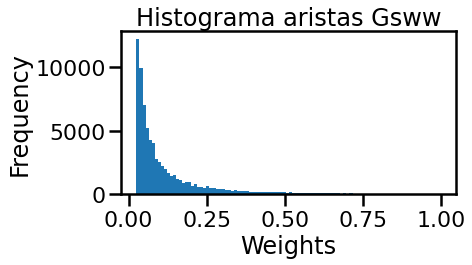

In [22]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(3)
plt.hist(df_0['frec'],bins=100)
plt.ylabel('Frequency')
plt.xlabel('Weights');
plt.title('Histograma aristas Gsww')

Esta fue la red sin sacar las palabras de w2v

# Comparando con las palabras de word2vec

In [23]:
# cargamos word2vec
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

w2v_model2 = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

--2021-12-12 12:30:35--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.128.16
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.128.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  33.5MB/s    in 50s     

2021-12-12 12:31:26 (31.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [24]:
# sacar palabras que no esten en w2v
l = [w for w in data['cue'] if w not in w2v_model2.vocab]
data_f = data[-data['cue'].isin(l)]
print(data_f.shape[0]) 

1025915


In [25]:
l = [w for w in data_f['R1'] if w not in w2v_model2.vocab]
data_f = data_f[-data_f['R1'].isin(l)]
print(data_f.shape[0])

1016391


In [26]:
#sacando los duplicados
data_f = data_f[data_f.duplicated()]
print(data_f.shape[0])

647788


#Frecuencia de aparicion de pares

In [27]:
# calculando frecuencia de aparicion de cada cue
df1 = data_f.groupby(['cue']).size().to_frame(name='size').reset_index()
df1_sorted = df1.sort_values(by=['size'],ascending=False).reset_index()
df1_sorted.head(5)

,index,cue,size
0,61,Cheddar,92
1,6881,mozzarella,92
2,6376,lyrics,91
3,267,Sahara,91
4,239,Parmesan,91


In [28]:
# calculando frecuencia de aparicion de cada par cue-R1
df2 = data_f.groupby(['cue','R1']).size().to_frame(name='size').reset_index()
df2_sorted = df2.sort_values(by=['size'],ascending=False).reset_index()
df2_sorted.head(5)

,index,cue,R1,size
0,566,Cheddar,cheese,92
1,2131,Parmesan,cheese,91
2,72731,moo,cow,90
3,52966,halt,stop,86
4,73459,mozzarella,cheese,85


In [29]:
df = df2.merge(df1,left_on='cue',right_on='cue')
df = df.rename(columns={'size_x':'frec_par','size_y':'frec_cue'})
df['frec'] = df['frec_par']/df['frec_cue']
df.head(5)

,cue,R1,frec_par,frec_cue,frec
0,Abel,Cain,54,59,0.915254
1,Abel,can,1,59,0.016949
2,Abel,cane,3,59,0.050847
3,Abel,religion,1,59,0.016949
4,Aboriginal,Australia,28,70,0.400000


In [30]:
# Recortando el grafo

df = df[(df['frec_par'] > 5) & (df['frec_cue'] > 10)]

# Sacar palabras que no estan mas en el cue y la R1
df.drop(df[df['R1'].isin(df['cue'].unique())==False].index, inplace=True)
df.drop(df[df['cue'].isin(df['R1'].unique())==False].index, inplace=True)
print(df.shape[0])

15735


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [31]:
df1 = df[['cue']].rename(columns={'cue':'word'},inplace=False) #dejando solo la palabra
df2 = df[['R1']].rename(columns={'R1':'word'},inplace=False)

df_dict = pd.concat([df1,df2])  # concatenando
list_dict = df_dict['word'].unique() #eliminando duplicados
list_dict.shape

(6039,)

In [32]:
print('numero nodos',len(list_dict))
print('numero maximo aristas (no dirigidas y sin loops)',len(list_dict)*(len(list_dict)-1)/2)
print('numero maximo aristas (dirigidas y sin loops)',len(list_dict)*(len(list_dict)-1))
print('numero maximo aristas (dirigidas y con loops)',len(list_dict)*(len(list_dict)))

numero nodos 6039
numero maximo aristas (no dirigidas y sin loops) 18231741.0
numero maximo aristas (dirigidas y sin loops) 36463482
numero maximo aristas (dirigidas y con loops) 36469521


#Distancias matrices w2v

Hacemos la matriz de distancias de todas contra todas

In [46]:
distancias_w2v_dict=np.zeros((len(list_dict),len(list_dict))) #matriz cuadrada
t = time.time()
print('Total de pares de palabras %d'%(len(list_dict)*(len(list_dict)-1)/2))
for i,ti in enumerate(list_dict):
  if i % 1000 ==0:
    print('Palabra %d: %.2f secs'%(i,time.time()-t))
  for j,tj in enumerate(list_dict):
    if j>i:
      distancias_w2v_dict[i,j] = abs(1-w2v_model2.similarity(ti,tj))


Total de pares de palabras 18231741
Palabra 0: 0.00 secs
Palabra 1000: 132.90 secs
Palabra 2000: 241.55 secs
Palabra 3000: 326.84 secs
Palabra 4000: 388.29 secs
Palabra 5000: 428.15 secs
Palabra 6000: 442.27 secs


In [47]:
distancias_w2v_dict = distancias_w2v_dict + distancias_w2v_dict.T
print(distancias_w2v_dict.shape)

(6039, 6039)


In [48]:
distancias_w2v_dict

array([[0.        , 0.74515241, 1.03994431, ..., 1.00914172, 1.02709306,
        0.96371075],
       [0.74515241, 0.        , 0.94273204, ..., 1.05086307, 1.0204471 ,
        0.87726942],
       [1.03994431, 0.94273204, 0.        , ..., 0.88340676, 1.08105043,
        0.78952371],
       ...,
       [1.00914172, 1.05086307, 0.88340676, ..., 0.        , 0.87195066,
        0.55743325],
       [1.02709306, 1.0204471 , 1.08105043, ..., 0.87195066, 0.        ,
        0.94796583],
       [0.96371075, 0.87726942, 0.78952371, ..., 0.55743325, 0.94796583,
        0.        ]])

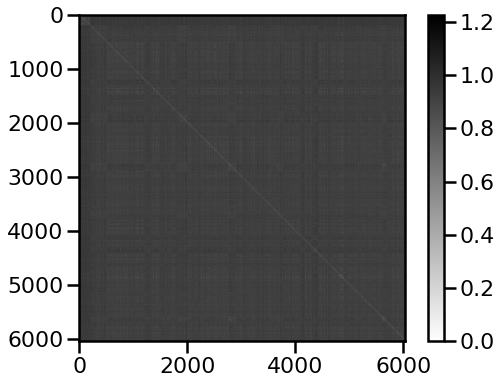

In [82]:
plt.imshow(distancias_w2v_dict,cmap='gray_r')
plt.colorbar()

Son muchos elementos, pero haciendo un zoom, se ven algunos conjuntos de nodos mas cercanos

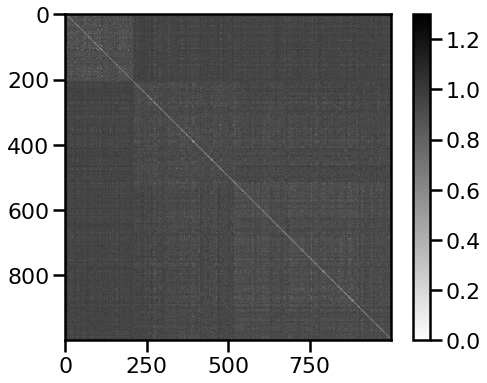

In [84]:
distancia_peque = distancias_w2v_dict[0:1000,0:1000]
plt.imshow(distancia_peque,cmap='gray_r',vmax=1.3,vmin=0)
plt.colorbar()

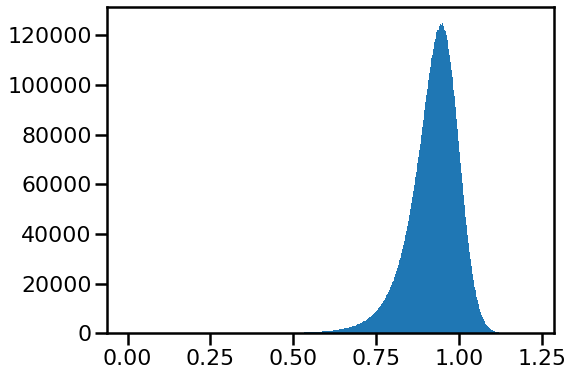

In [87]:
#El histograma de distancias
out = plt.hist(distancias_w2v_dict.flatten(),bins='auto')


El grafo:

In [33]:
G2 = nx.from_pandas_edgelist(df[['cue','R1','frec']],source='cue',target='R1',edge_attr=True)

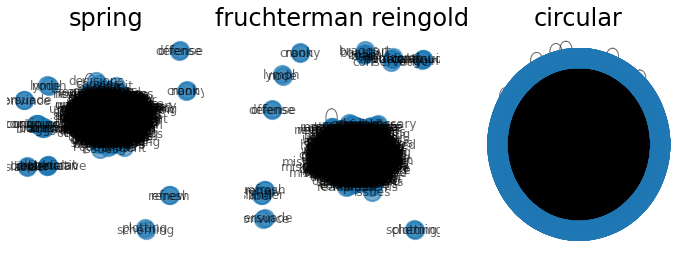

In [89]:
#Visualizando la red

plt.figure(figsize=(12,4))

plt.subplot(131)
nx.draw(G2, with_labels=True, alpha=0.6)
plt.title('spring')

plt.subplot(132)
layout=nx.fruchterman_reingold_layout(G2)
nx.draw(G2,layout, with_labels=True, alpha=0.6)
plt.title('fruchterman reingold')

plt.subplot(133)
layout=nx.circular_layout(G2)
nx.draw(G2,layout, with_labels=False,alpha=0.6)
plt.title('circular');

Aqui ya se ven comunidades

# Caracterizacion de los grafos

Red G_sww (G1)

Es pesada la red?

In [34]:
print(nx.info(G1))
print('Is weigthed:',nx.is_weighted(G1))

G1.number_of_nodes(), G1.number_of_edges()

Graph with 10251 nodes and 66514 edges
Is weigthed: False


(10251, 66514)

Red Gw2v

In [35]:
print(nx.info(G2))
print('Is weigthed:',nx.is_weighted(G2))

G2.number_of_nodes(), G2.number_of_edges()

Graph with 6039 nodes and 13337 edges
Is weigthed: False


(6039, 13337)

No se porque sale false en weighted, deberia ser true.

¿Las redes tienen loops o aristas múltiples? ¿Son redes completamente conectadas?

In [36]:
# Tienen multiples aristas (y self-loops)
G1.is_multigraph(), G2.is_multigraph()

(False, False)

In [37]:
# Están conectados?
nx.is_connected(G1), nx.is_connected(G2)

(True, False)

Diametro de la red (solo para G1 porque G2 es no conectado):
Correr este demora (da 7)

In [ ]:
nx.diameter(G1)

G1 es una red cohesiva, tiene diametro pequeño y está conectada

Densidad de la red:

In [39]:
nx.density(G1), nx.density(G2)

(0.0012660561372953502, 0.0007315264077084027)

Son redes muy "esparsas". La segunda es menos densa y esto es consistente con que no es cohesiva

Clustering global

In [40]:
nx.average_clustering(G1), nx.average_clustering(G2)

(0.2005921397367314, 0.19006500927225733)

Los elementos en ambas redes tienden a conectarse muy poco entre si

Asortividad (selectividad)

In [41]:
nx.degree_assortativity_coefficient(G1), nx.degree_assortativity_coefficient(G2)

(-0.13061991711587048, -0.12356487141072525)

las redes son disasortativas, los nodos conectados difieren mucho en sus grados

# Grado

Grados por nodo

In [42]:
df_grados = pd.DataFrame(G2.degree,columns=['Node','Degree']).set_index('Node')
df_grados.sort_values('Degree',ascending=False).T

Node,money,water,food,car,music,green,love,animal,red,old,paper,happy,game,work,drink,dog,fruit,school,sad,cold,fire,sex,tree,time,small,house,country,up,good,bird,book,hot,man,death,hair,black,white,light,ball,child,...,resistance,resolution,tails,respect,responsible,restless,retired,cosmetics,revolver,antique,rifle,ripped,countries,rival,occur,covered,moo,anarchy,announce,wellness,piles,annoyance,reckless,herbs,helping,continuing,held,continuous,convince,refresh,renew,persuade,register,registered,rejected,irritating,heavenly,release,remain,Abel
Degree,111,99,88,72,66,61,52,50,48,47,44,44,43,42,41,41,40,40,40,40,38,38,37,37,36,36,35,35,35,34,34,34,34,34,33,32,32,32,31,31,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Viendolos en un histograma

<Figure size 720x288 with 0 Axes>

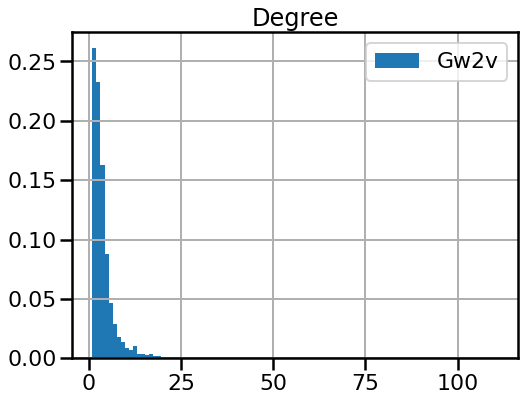

In [43]:
plt.figure(figsize=(10,4))
df_grados.hist(bins=100,density=True,label='Gw2v');
plt.legend()


Grado de los nodos:

In [44]:
results = powerlaw.Fit(df_grados['Degree'],discrete=True,)
results.power_law.alpha
results.power_law.sigma
R,p = results.distribution_compare('power_law', 'exponential')

Calculating best minimal value for power law fit


In [45]:
# si el primer numero es grande, la distribucion mas probable es la primera candidata
print(R,p)

122.47213949116946 1.5981025840156287e-07


Text(0.5, 0, 'grado')

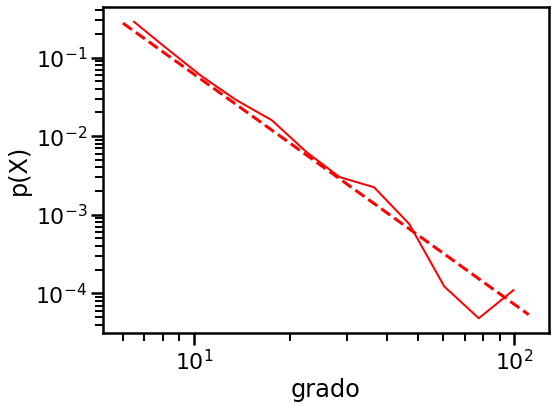

In [46]:
figPDF = results.plot_pdf(color='r', linewidth=2)
results.power_law.plot_pdf(color='r', linestyle='--', ax=figPDF)

####
figPDF.set_ylabel(u"p(X)")
figPDF.set_xlabel(r"grado")

Tiene forma de ley de potencias

Las distribuciones de grado comparadas:

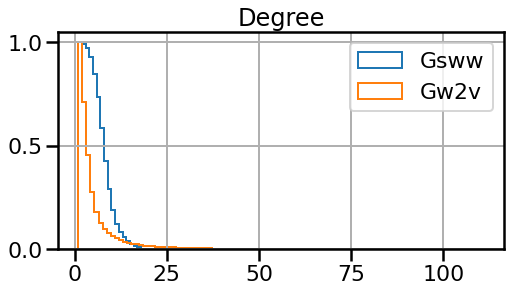

In [47]:
plt.figure(figsize=(8,4));
(np.sum(matriz,axis=1)).hist(density=True,histtype='step',label='Gsww', cumulative=-1,bins=20 );
df_grados.hist(density=True,ax=plt.gca(), histtype='step',label='Gw2v', cumulative=-1, bins=100);
plt.legend();

La Gw2v tiene distro de ley de potencias y la Gsww de small world

In [ ]:
#demora
#omega = nx.algorithms.smallworld.omega(G1, niter=60, nrand=4)

# Medidas de centralidad

Centralidad de grado

In [48]:
 pos_1 = nx.spring_layout(G1,k=0.2)
 pos_2 = nx.spring_layout(G2,k=0.2)

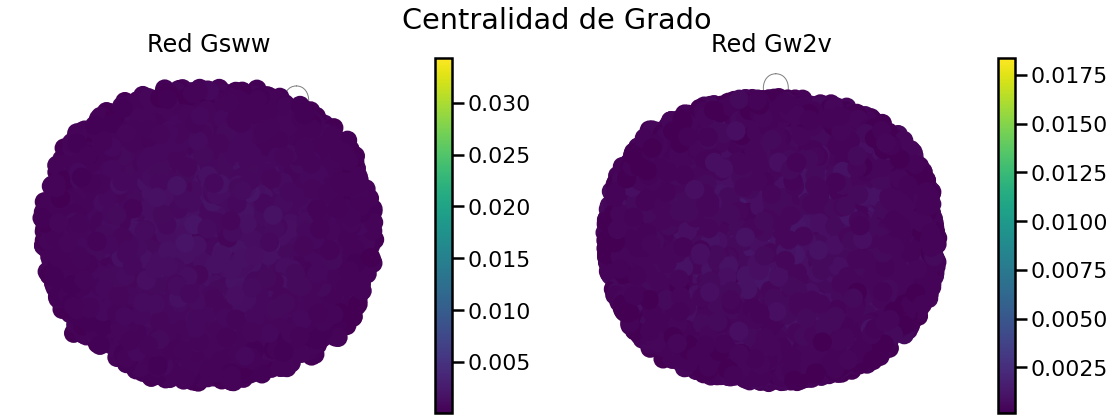

In [67]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.degree_centrality(G1)
values = [v for n,v in centrality.items()]
nx.draw(G1,pos=pos_1, with_labels=False,node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red Gsww');

centrality = nx.degree_centrality(G2)
values = [v for n,v in centrality.items()]
nx.draw(G2,pos=pos_2, with_labels=False,node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red Gw2v');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])

plt.suptitle('Centralidad de Grado',y=1.0)
plt.tight_layout();

Como sale muy fea esta visualizacion, grafico el histograma de centralidades

In [85]:
degCent1 = nx.degree_centrality(G1)
degCent2 = nx.degree_centrality(G2)
print(min(degCent1.values()),max(degCent1.values()))
print(min(degCent2.values()),max(degCent2.values()))

9.75609756097561e-05 0.03434146341463415
0.00016561775422325274 0.018383570718781054


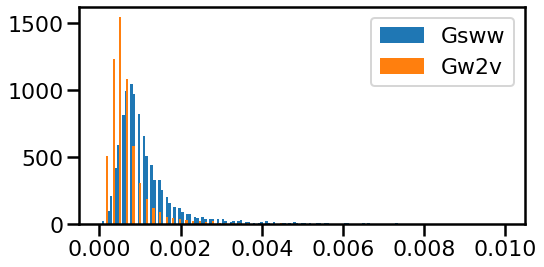

In [94]:

plt.figure(figsize=(8,4));
out1 = plt.hist(degCent1.values(),bins='auto',range=[0,0.01],label = 'Gsww')
out2 = plt.hist(degCent2.values(),bins='auto',range=[0,0.01],label = 'Gw2v')
plt.legend()

Ambas redes tienen nodos con centralidades pequeñas. La Gsww tiene mas nodos con centralidad ¨grande¨ que la Gw2v y centralidades mas ¨grandes¨

Las otras tres centralidades demoran, no correr.

Centralidad de betweeness

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.betweenness_centrality(G1)
values = [v for n,v in centrality.items()]
nx.draw(G1,pos=pos_1, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red Gsww');

centrality = nx.betweenness_centrality(G2)
values = [v for n,v in centrality.items()]
nx.draw(G2,pos=pos_2, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red Gw2v');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
plt.suptitle('Centralidad de Betweenness',y=1.0);
plt.tight_layout();

  Centralidad de cercania

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.closeness_centrality(G1)
values = [v for n,v in centrality.items()]
nx.draw(G1,pos=pos_1, with_labels=False,node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red Gsww');

centrality = nx.closeness_centrality(G2)
values = [v for n,v in centrality.items()]
nx.draw(G2,pos=pos_1, with_labels=False,node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red Gw2v');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
plt.suptitle('Centralidad de Cercanía',y=1.0);
plt.tight_layout();

Centralidad de autovector

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.eigenvector_centrality(G1)
values = [v for n,v in centrality.items()]
nx.draw(G1,pos=pos_1, with_labels=False, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red observada');

centrality = nx.eigenvector_centrality(G_2)
values = [v for n,v in centrality.items()]
nx.draw(G2,pos=pos_2, with_labels=False, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red percibida');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
plt.suptitle('Centralidad de Autovector',y=1.0);
plt.tight_layout();

# Deteccion de comunidades

In [49]:
from networkx.algorithms.community import modularity
import community.community_louvain as community_louvain

Deteccion con algoritmo de Louvain

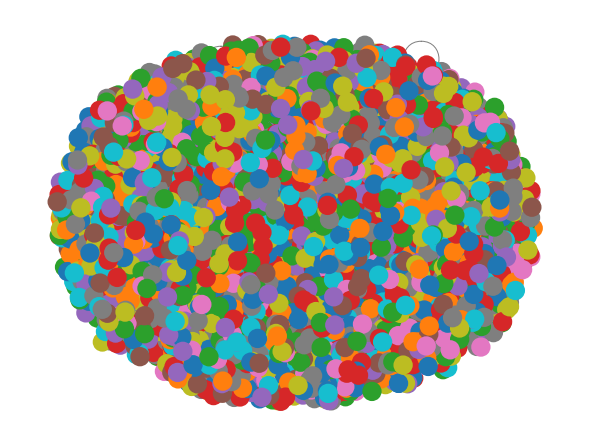

In [107]:
modulos = community_louvain.best_partition(G1)
values_1 = [v for n,v in modulos.items()]
nx.draw(G1,pos=pos_1, with_labels=False,cmap=plt.cm.tab10,node_color = values_1, edge_color='gray')

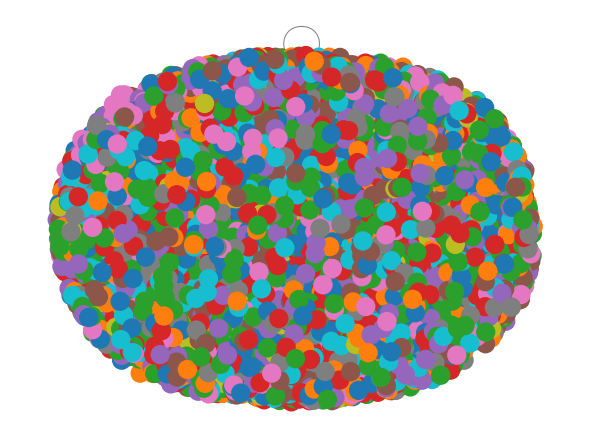

In [108]:
modulos = community_louvain.best_partition(G2)
values_2 = [v for n,v in modulos.items()]
nx.draw(G2,pos=pos_2, with_labels=False,cmap=plt.cm.tab10,node_color = values_2, edge_color='gray')

# Comparacion con redes small world

In [ ]:
repetitions = 100
dat = []
for i in range(repetitions):
    d = {}
    G_pl = nx.barabasi_albert_graph(G1.number_of_nodes(),10,seed=i)
    d['ba_avg_clus'] = nx.average_clustering(G_pl)
    d['ba_avg_path'] = nx.average_shortest_path_length(G_pl)
    d['ba_avg_degree'] = G_pl.number_of_edges()/G_pl.number_of_nodes()
    d['ba_alpha'] = powerlaw.Fit([d for n, d in G_pl.degree],discrete=True,xmin=8).alpha

    G_r = nx.gnm_random_graph(G1.number_of_nodes(),G1.number_of_edges(),seed=i)    
    d['er_avg_clus'] = nx.average_clustering(G_r)
    d['er_avg_path'] = nx.average_shortest_path_length(G_r)
    
    G_sw = nx.newman_watts_strogatz_graph(G1.number_of_nodes(),round(G1.number_of_edges()/G1.number_of_nodes()),0.03,seed=i)
    d['ws_avg_clus'] = nx.average_clustering(G_sw)
    d['ws_avg_path'] = nx.average_shortest_path_length(G_sw)
    dat.append(d)

df_s = pd.DataFrame(dat)
axs = df_s.filter(regex='avg_clus').hist(figsize=(12,8),density=True)
for ax in axs.flatten():
    ax.vlines(nx.average_clustering(G1),0,20,lw=3,color='r')

axs = df_s.filter(regex='avg_path').hist(figsize=(12,8),density=True)
for ax in axs.flatten():
    ax.vlines(nx.average_shortest_path_length(G1),0,20,lw=3,color='r')